# P5 - Segmentez des clients d'un site e-commerce

Vous êtes consultant pour Olist, une solution de vente sur les marketplaces en ligne.

Olist souhaite que vous fournissiez à ses équipes d'e-commerce une segmentation des clients qu’elles pourront utiliser au quotidien pour leurs campagnes de communication.

Votre objectif est de comprendre les différents types d’utilisateurs grâce à leur comportement et à leurs données personnelles.

Vous devrez fournir à l’équipe marketing une description actionable de votre segmentation et de sa logique sous-jacente pour une utilisation optimale, ainsi qu’une proposition de contrat de maintenance basée sur une analyse de la stabilité des segments au cours du temps.

**Les données**

Pour cette mission, Olist vous fournit une base de données anonymisée comportant des informations sur l’historique de commandes, les produits achetés, les commentaires de satisfaction, et la localisation des clients depuis janvier 2017.

**Votre mission**

Votre mission est d’aider les équipes d’Olist à comprendre les différents types d'utilisateurs. Vous utiliserez donc des méthodes non supervisées pour regrouper ensemble des clients de profils similaires. Ces catégories pourront être utilisées par l’équipe marketing pour mieux communiquer.

Pour des raisons de confidentialité, Olist ne fournit pas beaucoup de données, à vous de fouiller dans celles dont vous disposez et de créer les meilleures features pour les exploiter.

Enfin, votre client, Olist, a spécifié sa demande ainsi :

- La segmentation proposée doit être exploitable et facile d’utilisation pour l’équipe marketing.
- Vous évaluerez la fréquence à laquelle la segmentation doit être mise à jour, afin de pouvoir effectuer un devis de contrat de maintenance.
- Le code fourni doit respecter la convention PEP8, pour être utilisable par Olist.

# Partie 1 : Nettoyage et analyse du jeu de données

In [1]:
%load_ext pycodestyle_magic
%pycodestyle_on

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

sns.set()
plt.style.use('seaborn-whitegrid')

Les csvs sont à télécharger après création d'un compte Kaggle à cette adresse : https://www.kaggle.com/olistbr/brazilian-ecommerce

In [2]:
customers = pd.read_csv('olist_customers_dataset.csv')
geoloc = pd.read_csv('olist_geolocation_dataset.csv')
items = pd.read_csv('olist_order_items_dataset.csv')
payments = pd.read_csv('olist_order_payments_dataset.csv')
reviews = pd.read_csv('olist_order_reviews_dataset.csv')
orders = pd.read_csv('olist_orders_dataset.csv')
products = pd.read_csv('olist_products_dataset.csv')
sellers = pd.read_csv('olist_sellers_dataset.csv')
translation = pd.read_csv('product_category_name_translation.csv')

## Caractéristiques générales des datasets

- les datasets sont plutôt propres avec peu ou pas de valeurs nulles et pas de valeurs dupliquées.
- on analyse particulièrement les datasets que l'on va utiliser pour le clustering : customers, orders, items, reviews.
- on remarque que les données sont étalées sur 2 ans, et elles ne sont pas récentes (du 2016-09-04 au 2018-10-17).

In [3]:
datasets = [customers, geoloc, items, payments, reviews, orders, products,
            sellers, translation]
datasets_names = ["customers", "geoloc", "items", "payments", "reviews",
                  "orders", "products", "sellers", "translation"]

for d, n in zip(datasets, datasets_names):
    print(n, ':\n', d.columns, '\nshape:', d.shape, '\n')
    print(d.nunique(), '\n\nValeurs nulles :\n', d.isna().sum(), '\n')

customers :
 Index(['customer_id', 'customer_unique_id', 'customer_zip_code_prefix',
       'customer_city', 'customer_state'],
      dtype='object') 
shape: (99441, 5) 

customer_id                 99441
customer_unique_id          96096
customer_zip_code_prefix    14994
customer_city                4119
customer_state                 27
dtype: int64 

Valeurs nulles :
 customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64 

geoloc :
 Index(['geolocation_zip_code_prefix', 'geolocation_lat', 'geolocation_lng',
       'geolocation_city', 'geolocation_state'],
      dtype='object') 
shape: (1000163, 5) 

geolocation_zip_code_prefix     19015
geolocation_lat                717358
geolocation_lng                717613
geolocation_city                 8011
geolocation_state                  27
dtype: int64 

Valeurs nulles :
 geolocation_zip_code_prefix    0
geolocation_lat          

## Préparation du dataset pour le clustering

In [4]:
customers = customers[['customer_id',
                       'customer_unique_id']]
orders = orders[['order_id',
                 'customer_id',
                 'order_purchase_timestamp',
                 'order_status']]
items = items[['order_id',
               'price']]

# On a parfois plusieurs notes pour une même commande
# on garde la plus récente
reviews.sort_values(by='review_creation_date',
                    ascending=False,
                    inplace=True)
reviews.drop_duplicates(subset='order_id',
                        inplace=True)
reviews = reviews[['order_id',
                   'review_score']]

data = (customers.merge(orders, on='customer_id')
                 .merge(items, on='order_id')
                 .merge(reviews, on='order_id'))
data.shape

(112650, 7)

In [5]:
print("Les commandes sont étalées du",
      orders.order_purchase_timestamp.min(), "au",
      orders.order_purchase_timestamp.max())

Les commandes sont étalées du 2016-09-04 21:15:19 au 2018-10-17 17:30:18


In [6]:
# On retire les commandes avec un statut "canceled" ou "unavailable"

print(set(data.order_status.tolist()))
data = data[~data['order_status'].isin(['canceled', 'unavailable'])]
data.shape

{'canceled', 'delivered', 'approved', 'processing', 'unavailable', 'shipped', 'invoiced'}


(112101, 7)

In [7]:
data.to_csv("raw_data.csv", index=False)
data.head()

,customer_id,customer_unique_id,order_id,order_purchase_timestamp,order_status,price,review_score
0,06b8999e2fba1a1fbc88172c00ba8bc7,861eff4711a542e4b93843c6dd7febb0,00e7ee1b050b8499577073aeb2a297a1,2017-05-16 15:05:35,delivered,124.99,4
1,18955e83d337fd6b2def6b18a428ac77,290c77bc529b7ac935b93aa66c333dc3,29150127e6685892b6eab3eec79f59c7,2018-01-12 20:48:24,delivered,289.00,5
2,4e7b3e00288586ebd08712fdd0374a03,060e732b5b29e8181a18229c7b0b2b5e,b2059ed67ce144a36e2aa97d2c9e9ad2,2018-05-19 16:07:45,delivered,139.94,5
3,b2b6027bc5c5109e529d4dc6358b12c3,259dac757896d24d7702b9acbbff3f3c,951670f92359f4fe4a63112aa7306eba,2018-03-13 16:06:38,delivered,149.94,5
4,4f2d8ab171c80ec8364f7c12e35b23ad,345ecd01c38d18a9036ed96c73b8d066,6b7d50bd145f6fc7f33cebabd7e49d0f,2018-07-29 09:51:30,delivered,230.00,5


In [8]:
# on simule des données plus récentes en considérant que la dernière vente
# a eu lieu la veille

now = datetime.strptime(orders['order_purchase_timestamp'].max(),
                        '%Y-%m-%d %H:%M:%S') + timedelta(days=1)
now

datetime.datetime(2018, 10, 18, 17, 30, 18)

In [9]:
# On ajoute les variables recency, frequency, monetary
# et les variables avg_buy et satisfaction

# recency = date du dernier achat en nombre de jours
data['recency'] = (data.groupby('customer_unique_id')
                   .order_purchase_timestamp.transform('max'))
data['recency'] = (data.recency
                   .apply(lambda x:
                          (now -
                           datetime.strptime(x, '%Y-%m-%d %H:%M:%S'))
                          .days))

# frequency = nombre de commandes par client
data['frequency'] = (data.groupby('customer_unique_id')
                     .customer_id.transform('nunique'))

# monetary = somme des achats totaux ou panier moyen
data['monetary'] = (data.groupby('customer_unique_id')
                    .price.transform('sum'))
data['avg_buy'] = data['monetary'] / data['frequency']

# satisfaction = moyenne des notes des commandes par client
data.drop_duplicates(subset='order_id',
                     inplace=True)
data['satisfaction'] = (data.groupby('customer_unique_id')
                        .review_score.transform('mean'))
data['satisfaction'] = round(data.satisfaction).astype(int)

In [10]:
data = (data[['customer_unique_id',
              'recency',
              'frequency',
              'monetary',
              'avg_buy',
              'satisfaction']].drop_duplicates())

data.shape

(94983, 6)

## Analyse des variables

- fréquence : très grande majorité d'achats uniques (97%)
- satisfaction : majorité de clients satisfaits mais plus variable que la fréquence, pourrait la remplacer dans notre RFM modifié
- dernières commandes réparties de manière assez homogène sur la dernière année
- la distribution des montants est étalée vers la droite
- le panier moyen et le montant total par client sont très similaires, ce qui s'explique par le nombre majoritaire de commandes uniques, on peut garder une seule des deux variables
- Les autres variables ne semblent pas corrélées entre elles

In [11]:
data.describe()

,recency,frequency,monetary,avg_buy,satisfaction
count,94983.000000,94983.000000,94983.000000,94983.000000,94983.000000
mean,287.960761,1.033859,142.071747,137.908349,4.097849
std,152.981551,0.210811,216.074999,210.132883,1.328752
min,45.000000,1.000000,0.850000,0.850000,1.000000
25%,164.000000,1.000000,47.900000,46.330000,4.000000
50%,269.000000,1.000000,89.890000,87.020000,5.000000
75%,397.000000,1.000000,155.000000,149.900000,5.000000
max,773.000000,16.000000,13440.000000,13440.000000,5.000000


In [12]:
freq = data.copy()
freq['nb_customers'] = (freq.groupby(['frequency'])
                        .customer_unique_id.transform('count'))
freq['ratio_customers'] = freq['nb_customers'] / len(freq)
freq.drop_duplicates(subset='frequency', inplace=True)
freq = freq.sort_values(by='frequency').set_index('frequency')
freq['cum_ratio'] = freq['ratio_customers'].cumsum()
freq = freq[['nb_customers', 'ratio_customers', 'cum_ratio']]
freq

,nb_customers,ratio_customers,cum_ratio
frequency,,,
1,92096,0.969605,0.969605
2,2651,0.027910,0.997515
3,188,0.001979,0.999495
4,29,0.000305,0.999800
5,9,0.000095,0.999895
6,5,0.000053,0.999947
7,3,0.000032,0.999979
9,1,0.000011,0.999989
16,1,0.000011,1.000000


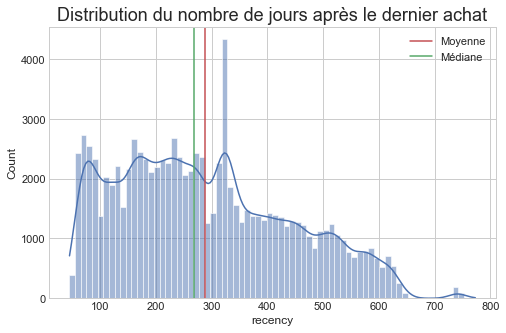

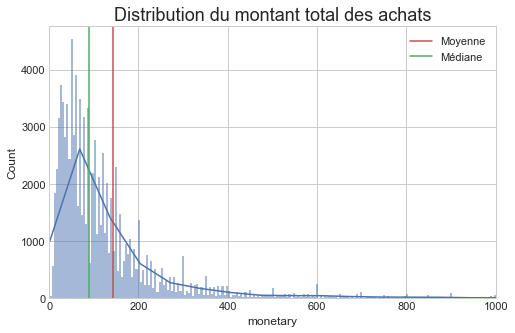

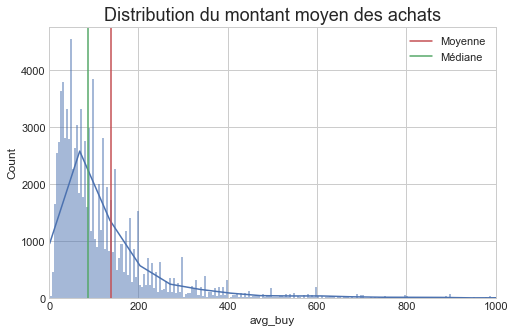

In [13]:
def create_histplot(var, title, x_max=0, y_max=0):
    fig = plt.figure(figsize=(8, 5))
    ax = sns.histplot(var, kde=True)
    if y_max != 0:
        plt.ylim(0, y_max)
    if x_max != 0:
        plt.xlim(0, x_max)
    line = plt.axvline(var.mean(), color='r')
    line2 = plt.axvline(var.median(), color='g')
    plt.title(title, fontsize=18)
    ax.legend([line, line2], ['Moyenne', 'Médiane'])


create_histplot(data['recency'],
                'Distribution du nombre de jours'
                ' après le dernier achat')
create_histplot(data['monetary'],
                'Distribution du montant total des achats',
                1000)
create_histplot(data['avg_buy'],
                'Distribution du montant moyen des achats',
                1000)

Text(0.5, 1.0, 'Proportion des scores de satisfaction')

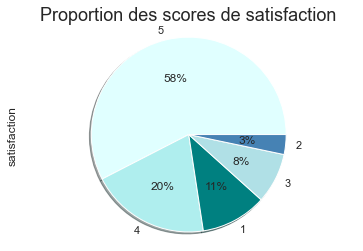

In [14]:
# Diagramme en secteurs
(data["satisfaction"].value_counts(normalize=True)
 .plot(kind='pie', shadow=True,
       colors=['lightcyan', 'paleturquoise', 'teal',
               'powderblue', 'steelblue'],
       autopct='%1.0f%%'))

# Cette ligne assure que le pie chart est un cercle plutôt qu'une ellipse
plt.axis('equal')
plt.title('Proportion des scores de satisfaction', size=18)

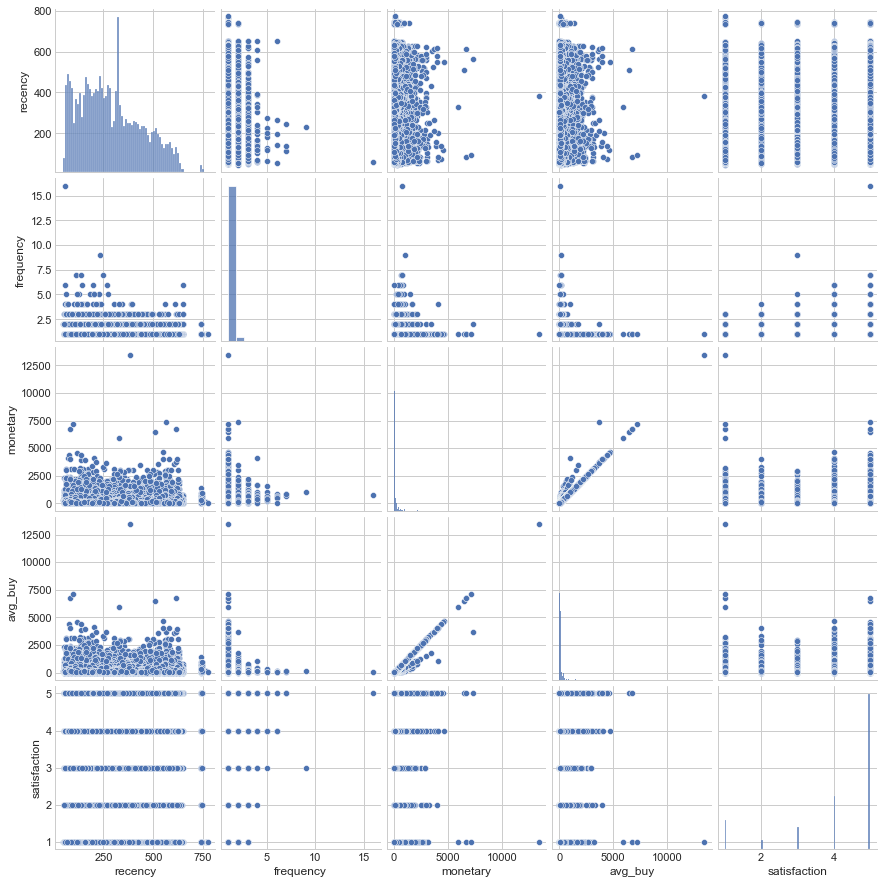

In [15]:
sns.pairplot(data)

Text(0.5, 1.0, 'Matrice de corrélation')

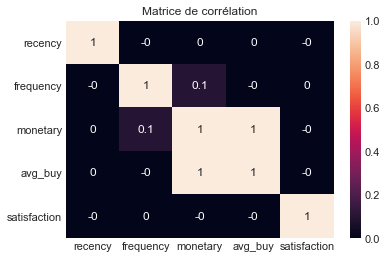

In [16]:
matrice_corr = data.corr().round(1)
sns.heatmap(data=matrice_corr, annot=True)
plt.title('Matrice de corrélation')

## Outliers

- Pas d'outliers visibles pour la variable "recency" ni "satisfaction".
- Pour "frequency", la proportion d'achats uniques est très élevée, les fréquences de 2 ou plus pourraient être considérées comme des outliers mais c'est une information utile, on perdrait trop d'information si on les retirait et la variable perdrait son utilité.
- Pour "monetary" si on utilise la méthode du zscore > 3, les achats de plus de 700€ seraient considérés comme des outliers. Les entrées chères sont des produits d'informatique, d'électroménager, d'instruments de musique... Ou des entrées à fréquence élevée. Rien d'aberrant, on considère l'information comme utile et on va choisir de garder les outliers.

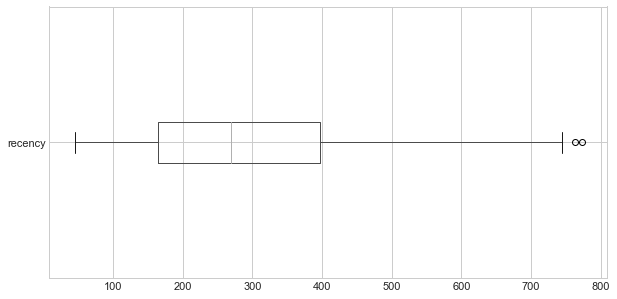

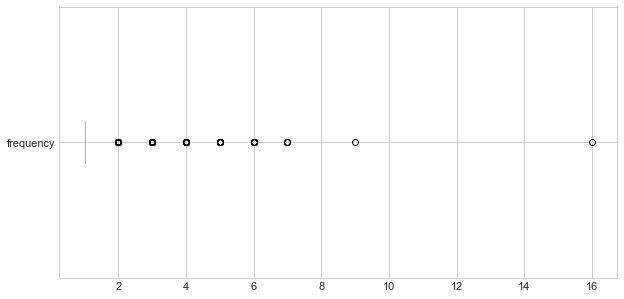

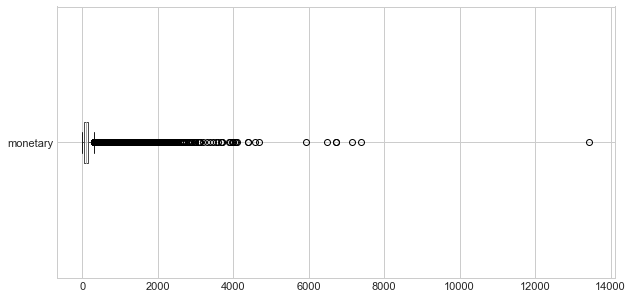

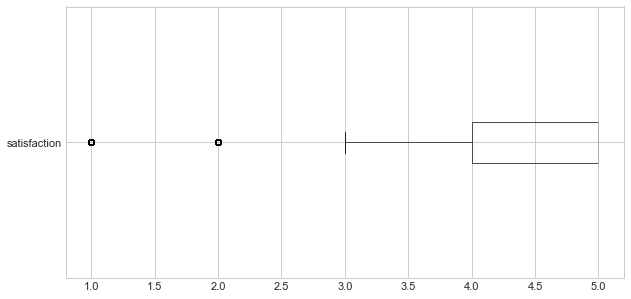

In [17]:
for col in ['recency', 'frequency', 'monetary', 'satisfaction']:
    fig = plt.figure(figsize=(10, 5))
    data.boxplot(column=col, vert=False)
    plt.show()

In [18]:
data['zscore_frequency'] = ((data.frequency - data.frequency.mean()) /
                            data.frequency.std())
data['zscore_monetary'] = ((data.monetary - data.monetary.mean()) /
                           data.monetary.std())
data['zscore_satisfaction'] = ((data.satisfaction - data.satisfaction.mean()) /
                               data.satisfaction.std())

In [19]:
data[data['zscore_frequency'] >= 3].describe()

,recency,frequency,monetary,avg_buy,satisfaction,zscore_frequency,zscore_monetary,zscore_satisfaction
count,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000,2887.000000
mean,271.083131,2.113959,259.947499,122.970689,4.108417,5.123555,0.545532,0.007953
std,144.605682,0.508932,297.225386,138.193963,1.132746,2.414165,1.375566,0.852488
min,45.000000,2.000000,11.980000,5.990000,1.000000,4.582980,-0.602068,-2.331397
25%,155.000000,2.000000,113.060000,54.940000,4.000000,4.582980,-0.134267,-0.073640
50%,250.000000,2.000000,181.980000,89.195000,4.000000,4.582980,0.184696,-0.073640
75%,370.000000,2.000000,303.995000,145.000000,5.000000,4.582980,0.749384,0.678946
max,741.000000,16.000000,7388.000000,3694.000000,5.000000,70.993263,33.534320,0.678946


In [20]:
data[data['zscore_monetary'] >= 3].describe()

,recency,frequency,monetary,avg_buy,satisfaction,zscore_frequency,zscore_monetary,zscore_satisfaction
count,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000,1664.000000
mean,286.550481,1.095553,1308.901587,1261.486924,3.915865,0.292652,5.400115,-0.136958
std,155.462126,0.462553,711.713208,712.827939,1.499694,2.194161,3.293825,1.128648
min,53.000000,1.000000,790.860000,111.205556,1.000000,-0.160612,3.002607,-2.331397
25%,158.000000,1.000000,899.000000,879.942500,3.000000,-0.160612,3.503081,-0.826225
50%,265.000000,1.000000,1099.000000,1054.000000,5.000000,-0.160612,4.428686,0.678946
75%,406.000000,1.000000,1458.247500,1437.000000,5.000000,-0.160612,6.091291,0.678946
max,743.000000,9.000000,13440.000000,13440.000000,5.000000,37.788121,61.543114,0.678946


In [21]:
data.drop(columns=['zscore_frequency', 'zscore_monetary',
                   'zscore_satisfaction'], inplace=True)
data.to_csv("data.csv", index=False)